# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
ca

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:07<00:00, 60.2MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '/content/data/s1/bbaf3s.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/content/data/s1/bbaf3s'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

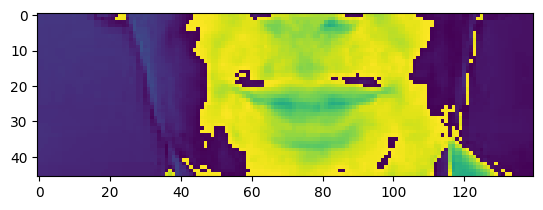

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20,  8, 18,
        5,  5, 39, 19, 15, 15, 14])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
frames[0]

array([[[[1.449862  ],
         [1.4880162 ],
         [1.1827822 ],
         ...,
         [0.3052341 ],
         [0.26707986],
         [0.26707986]],

        [[1.4880162 ],
         [1.3353993 ],
         [1.0301651 ],
         ...,
         [0.3052341 ],
         [0.26707986],
         [0.26707986]],

        [[1.4880162 ],
         [1.4880162 ],
         [1.3735535 ],
         ...,
         [0.34338838],
         [0.3052341 ],
         [0.3052341 ]],

        ...,

        [[1.0683194 ],
         [1.0683194 ],
         [1.0683194 ],
         ...,
         [0.03815426],
         [0.03815426],
         [0.03815426]],

        [[1.0301651 ],
         [1.0301651 ],
         [1.0301651 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[1.0301651 ],
         [1.0301651 ],
         [1.0301651 ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[1.4117078 ],
         [1.5643249 ],
         [1.25

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()
sample

In [ ]:
val = sample.next(); val[0]

array([[[[[1.5771023 ],
          [1.5771023 ],
          [1.6137791 ],
          ...,
          [0.        ],
          [0.36676797],
          [0.29341438]],

         [[1.5771023 ],
          [1.5771023 ],
          [1.6137791 ],
          ...,
          [0.        ],
          [0.29341438],
          [0.22006078]],

         [[1.5404255 ],
          [1.5404255 ],
          [1.5404255 ],
          ...,
          [0.2567376 ],
          [0.36676797],
          [0.36676797]],

         ...,

         [[1.0636271 ],
          [1.0636271 ],
          [1.0636271 ],
          ...,
          [0.18338399],
          [0.14670719],
          [0.14670719]],

         [[1.0636271 ],
          [1.0636271 ],
          [1.0636271 ],
          ...,
          [0.14670719],
          [0.14670719],
          [0.14670719]],

         [[1.0636271 ],
          [1.0636271 ],
          [1.0636271 ],
          ...,
          [0.14670719],
          [0.14670719],
          [0.11003039]]],


        [[[1.5771

In [ ]:
val[0][0]

array([[[[1.5771023 ],
         [1.5771023 ],
         [1.6137791 ],
         ...,
         [0.        ],
         [0.36676797],
         [0.29341438]],

        [[1.5771023 ],
         [1.5771023 ],
         [1.6137791 ],
         ...,
         [0.        ],
         [0.29341438],
         [0.22006078]],

        [[1.5404255 ],
         [1.5404255 ],
         [1.5404255 ],
         ...,
         [0.2567376 ],
         [0.36676797],
         [0.36676797]],

        ...,

        [[1.0636271 ],
         [1.0636271 ],
         [1.0636271 ],
         ...,
         [0.18338399],
         [0.14670719],
         [0.14670719]],

        [[1.0636271 ],
         [1.0636271 ],
         [1.0636271 ],
         ...,
         [0.14670719],
         [0.14670719],
         [0.14670719]],

        [[1.0636271 ],
         [1.0636271 ],
         [1.0636271 ],
         ...,
         [0.14670719],
         [0.14670719],
         [0.11003039]]],


       [[[1.5771023 ],
         [1.5771023 ],
         [1.54

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

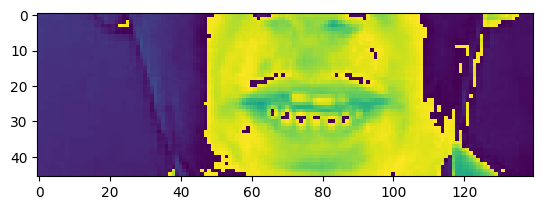

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 3:03 - loss: 213.9969 


KeyboardInterrupt



# 5. Make a Prediction

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
sample[0]

array([[[[[ 1.4673755 ],
          [ 1.4673755 ],
          [ 1.4673755 ],
          ...,
          [ 0.04192502],
          [ 0.04192502],
          [ 0.04192502]],

         [[ 1.4673755 ],
          [ 1.4673755 ],
          [ 1.4673755 ],
          ...,
          [ 0.04192502],
          [ 0.04192502],
          [ 0.04192502]],

         [[ 1.5093006 ],
          [ 1.5093006 ],
          [ 1.4673755 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 1.0062004 ],
          [ 1.0062004 ],
          [ 1.0062004 ],
          ...,
          [10.481254  ],
          [10.481254  ],
          [10.481254  ]],

         [[ 1.0062004 ],
          [ 1.0062004 ],
          [ 1.0062004 ],
          ...,
          [10.439329  ],
          [10.439329  ],
          [10.439329  ]],

         [[ 1.0062004 ],
          [ 1.0062004 ],
          [ 1.0062004 ],
          ...,
          [10.439329  ],
          [10.439329  ],
          

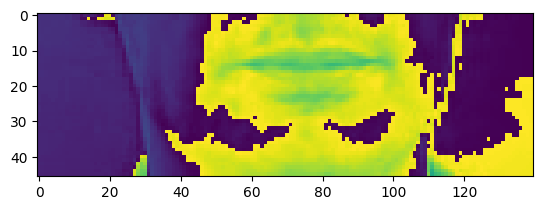

In [ ]:
from random import randint
plt.imshow(sample[0][0][randint(0,75)])


In [ ]:
sample[0][0]

array([[[[ 1.4673755 ],
         [ 1.4673755 ],
         [ 1.4673755 ],
         ...,
         [ 0.04192502],
         [ 0.04192502],
         [ 0.04192502]],

        [[ 1.4673755 ],
         [ 1.4673755 ],
         [ 1.4673755 ],
         ...,
         [ 0.04192502],
         [ 0.04192502],
         [ 0.04192502]],

        [[ 1.5093006 ],
         [ 1.5093006 ],
         [ 1.4673755 ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        ...,

        [[ 1.0062004 ],
         [ 1.0062004 ],
         [ 1.0062004 ],
         ...,
         [10.481254  ],
         [10.481254  ],
         [10.481254  ]],

        [[ 1.0062004 ],
         [ 1.0062004 ],
         [ 1.0062004 ],
         ...,
         [10.439329  ],
         [10.439329  ],
         [10.439329  ]],

        [[ 1.0062004 ],
         [ 1.0062004 ],
         [ 1.0062004 ],
         ...,
         [10.439329  ],
         [10.439329  ],
         [10.439329  ]]],


       [[[ 1.4673755 ],


In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 282ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
real=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]
real_txt=real[0].numpy().decode()
real_txt

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


'bin white in g two please'

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
pred=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
pred_text=pred[0].numpy().decode()
pred_text

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


'bin white in g two please'

In [ ]:
def calculate_accuracy(real_text, predicted_text):
    total_chars = len(real_text)
    correct_chars = sum([1 for r, p in zip(real_text, predicted_text) if r == p])
    accuracy = correct_chars / total_chars * 100
    return accuracy

In [ ]:
calculate_accuracy(real_txt,pred_text)

100.0

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

r1=[real_txt]
p1=[pred_text]
# Compute confusion matrix
cm = confusion_matrix(r1,p1)
print("Confusion Matrix:")
print(cm)

# Compute accuracy
accuracy = accuracy_score(r1,p1)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1]]
Accuracy: 1.0


# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbaf3s.mpg'))

In [ ]:
video, annotations = load_data(tf.convert_to_tensor('/content/data/s1/bbal9a.mpg'))
imageio.mimsave('animation3.gif', video, fps=10)


In [ ]:
#test on gif store
video, annotations = load_data(tf.convert_to_tensor('/content/data/s1/bbal9a.mpg'))
vid=imageio.mimsave('animation3_dupl.gif', video, fps=10)
vid

In [ ]:
print('~'*100, 'REAL TEXT')

[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 839ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at j three soon'>]

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [ ]:
#FINAL DEMO SHOWCASE


import gradio as gr
import glob
import cv2


video_files = glob.glob("/content/data/s1/*.mpg")
video_choices = {file.split("/")[-1]: file for file in video_files}
video_choice_input = gr.inputs.Dropdown(choices=list(video_choices.keys()), label="Select a video")

output_text = gr.outputs.Textbox(label="Predictions")
vid=gr.outputs.Video(label="Video")
lip=gr.outputs.Video(label="Lip movement")


def predict_on_video(file):
    sample= load_data(tf.convert_to_tensor('/content/data/s1/'+file))
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
    predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    return [prediction.numpy().decode() for prediction in predictions],[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]][0].numpy().decode()


def video_prediction(video_choice,vid):
    predictions,real= predict_on_video(video_choices[video_choice])
    sample,ann = load_data(tf.convert_to_tensor('/content/data/s1/'+video_choice))
    #img= sample[0][0][randint(0,75)]  # Assuming sample[0][0][35] is an image
    vid_path='/content/data/s1/'+video_choice
    imageio.mimsave(video_choice[:-4]+'.gif', sample, fps=10)
    vid_name=video_choice[:-4]+'.gif'

    #vid=output_video(vid_path)
    vid=gr.outputs.Video(vid_path)
    return {
        #'Real Text': [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]][0].numpy().decode(),
        'Predictions': predictions[0],
        'Real Text':real,
      #  'Sample':sample
    },vid_path,vid_name



#gr.Interface(fn=video_prediction, inputs=[video_choice_input], outputs=[output_text,'video','video'], title="Video Prediction").launch()
gr.Interface(fn=video_prediction, inputs=[video_choice_input], outputs=[output_text,vid,lip], title="Lip Net").launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:219: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:222: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:63: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:766: UserWarning: Expected 2 arguments for function <function video_prediction at 0x7fc17c2a7910>, received 1.
  warnin

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>